# import library

In [ ]:
!pip install sastrawi

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
import datetime as dt
from textblob import TextBlob
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.metrics import classification_report, confusion_matrix

import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from nltk.corpus import stopwords
stopwords=  nltk.corpus.stopwords.words('indonesian')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 3.3 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
!pip install google-play-scraper #instalasi modul untuk scraping data dari playstore

In [ ]:
import warnings
warnings.filterwarnings("ignore")
from google_play_scraper import app #import library app google play scraper

In [ ]:
from google_play_scraper import Sort, reviews  #import review dan sorting dari playstore scraper

result, continuation_token = reviews(
    'com.maxstream',
    lang='id',
    country='id',
    sort=Sort.MOST_RELEVANT,
    count=100000, # mengambil 1000 data
    filter_score_with=None
)

In [ ]:
data = pd.DataFrame(np.array(result), columns=['review']) #mengambil kolom review

data = data.join(pd.DataFrame(data.pop('review').tolist()))

data #menampilkan seluruh data

In [ ]:
scrappeddata1 = data[['content','score','at']] #hanya mengambil 3kolom yaitu: content, score, at
sorteddata = scrappeddata1.sort_values(by='at', ascending=True) #disorting berdasarkan review terbaru
sorteddata.head()

In [ ]:
sorteddata.info() #menampilkan informasi sorted data

In [ ]:
sorteddata['Year'] = sorteddata['at'].dt.year #memisahkan kolom tahun
sorteddata['Month'] = sorteddata['at'].dt.month #memisahkan kolom bulan
sorteddata['Day'] = sorteddata['at'].dt.day #memisahkan kolom hari
sorteddata

In [ ]:
df = sorteddata[['content','score','Year','Month','Day']] #variabel df diisi dengan kolom content,score,year,month,day dari sorted data
df #menampilkan dataframe df

In [ ]:
df['score'].value_counts() #menghitung total masing2 score rating dengan skala 1-5

# Labelling sentimen

In [ ]:
sentimen = []
for index, row in df.iterrows():
    if row['score'] <= 3 :
        sentimen.append(0)
    else:
        sentimen.append(1)
df['sentiment'] = sentimen
df.head(50)

In [ ]:
df['sentiment'].value_counts() #menghitung total masing2 nilai sentiment baik negative, netral maupun positif

In [ ]:
df.to_csv('maxstream 70k.csv')
df.to_excel('maxstream 70k.xlsx')

# Data Gatering

In [ ]:
!gdown --id 1BPMOIfzcV7-Svv6dKFmVmO6ofrffUbSp

maxs = pd.read_csv('maxstream 70k.csv')
maxs.head()

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1BPMOIfzcV7-Svv6dKFmVmO6ofrffUbSp
To: /content/maxstream 70k.csv
100% 5.23M/5.23M [00:00<00:00, 38.1MB/s]


,Unnamed: 0,content,score,Year,Month,Day,sentiment
0,57583,Padahal bagus kalau bisa putar lewat aplikanya...,3,2018,3,29,0
1,61533,Coba dulu,3,2018,4,2,0
2,61757,coba dulu,4,2018,4,3,1
3,58119,Kirain diputar lg eh harus download aplikasi s...,4,2018,4,4,1
4,66721,oky,5,2018,4,7,1


In [ ]:
maxs = maxs[['content','sentiment']]

In [ ]:
maxs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69617 entries, 0 to 69616
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   content    69617 non-null  object
 1   sentiment  69617 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


data berjumlah 2010 dan tidak ada missing value

# Data preparation

## Handling Duplicate

In [ ]:
maxs.duplicated().sum()

17251

In [ ]:
maxs.drop_duplicates(inplace=True)

In [ ]:
maxs.duplicated().sum()

0

Terdapat 2 duplicate pada data dan sudah di handling dengan menghapus data tersebut

## Data Cleaning

In [ ]:
# Menghapus URL
maxs['content'] = maxs['content'].str.replace(r'https\S+', ' ', regex=True)

# Mengubah menjadi huruf kecil
maxs['content'] = maxs['content'].str.lower()

# Menghapus mention (seperti @username)
maxs['content'] = maxs['content'].str.replace(r'@\S+', ' ', regex=True)

# Menghapus hashtag (seperti #hashtag)
maxs['content'] = maxs['content'].str.replace(r'#\S+', ' ', regex=True)

# Menghapus karakter setelah tanda petik (seperti 'satu menjadi satu)
maxs['content'] = maxs['content'].str.replace(r"\'\w+", ' ', regex=True)

# Menghapus tanda baca
maxs['content'] = maxs['content'].str.replace(r'[^\w\s]', ' ', regex=True)

# Menghapus white space berlebih
maxs['content'] = maxs['content'].str.replace(r'\s+', ' ', regex=True)

# Menghapus angka dalam ulasan
maxs['content'] = maxs['content'].str.replace(r'\d+', ' ', regex=True)

# Menghapus pengulangan karakter berlebih, seperti "aaa" menjadi "aa"
maxs['content'] = maxs['content'].str.replace(r'(.)\1+', r'\1\1', regex=True)

# Membatasi pengulangan kata, seperti "suka suka" menjadi "suka"
maxs['content'] = maxs['content'].str.replace(r'\b(\w+)(?:\W\1\b)+', r'\1', regex=True)

# Menghapus emoji
maxs['content'] = maxs['content'].str.replace(r'[^\w\s,.!?@#%^&*()\[\]{}<>;:/\\|+=~`\'\"-]', ' ', regex=True)

# Menghapus kata yang terdiri dari 2 huruf
maxs['content'] = maxs['content'].str.replace(r'\b\w{2}\b', '', regex=True)

# Menghapus kata yang terdiri dari satu huruf
maxs['content'] = maxs['content'].str.replace(r'\b\w{1}\b', '', regex=True)

In [ ]:
# Fungsi untuk menghapus emoji
def remove_emoji(text):
    emoji_pattern = re.compile("["
                                u"\U0001F600-\U0001F64F"  # Emoticons
                                u"\U0001F300-\U0001F5FF"  # Symbols & Pictographs
                                u"\U0001F680-\U0001F6FF"  # Transport & Map Symbols
                                u"\U0001F1E0-\U0001F1FF"  # Flags (iOS)
                                u"\U00002700-\U000027BF"  # Dingbats
                                u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                                u"\U00002600-\U000026FF"  # Miscellaneous Symbols
                                u"\U0001F018-\U0001F270"  # Alphanumeric symbols
                                u"\U0001F600-\U0001F64F"  # Emoticons
                                "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

# Membersihkan data di kolom 'content'
maxs['content'] = maxs['content'].apply(remove_emoji)

In [ ]:
maxs.head()

,content,sentiment
0,padahal bagus kalau bisa putar lewat aplikanya...,0
1,coba dulu,0
2,coba dulu,1
3,kirain diputar harus download aplikasi strea...,1
4,oky,1


## merubah slang ke standard (normalization)

In [ ]:
!gdown --id 1cXaOtuw6xqWL6KDjZqvkzGYsiyyr0X1y

slangs = open('slang.txt',"r",encoding="utf-8", errors='replace')

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1cXaOtuw6xqWL6KDjZqvkzGYsiyyr0X1y
To: /content/slang.txt
100% 32.8k/32.8k [00:00<00:00, 41.1MB/s]


In [ ]:
clear_slangs= []
for newlines in slangs:
  strip_re = newlines.strip("\n")
  split = re.split(r'[:]',strip_re)
  clear_slangs.append(split)

print(clear_slangs)

[['& ', ' dan'], ['dr ', ' dari'], ['abis ', ' habis'], ['ad ', ' ada'], ['alhmdulillah ', ' alhamdulillah'], ['alhamdulilah ', ' alhamdulillah'], ['alhamdulillaah ', ' alhamdulillah'], ['alhamdulillah ', ' alhamdulillah'], ['adminnya ', ' admin nya'], ['account ', ' akun'], ['asiikk ', ' asyik'], ['alpukatnya ', ' alpukat nya'], ['amin ', ' aamiin'], ['aplikasinnya ', ' aplikasi nya'], ['aplikasinya ', ' aplikasi nya'], ['awesome ', ' luar biasa'], ['asyilk ', ' asyik'], ['antaran ', ' pengantaran'], ['apus ', ' hapus'], ['ampe ', ' sampai'], ['almt ', ' alamat'], ['almat ', ' alamat'], ['alamt ', ' alamat'], ['almtnya ', ' alamatnya'], ['apknya ', ' aplikasinya'], ['antri ', ' antre'], ['adl ', ' adalah'], ['awalnnya ', ' awalnya'], ['asem ', ' asam'], ['alumunium ', ' aluminium'], ['abis ', ' habis'], ['areaku ', ' area saya'], ['alpulat ', ' alpukat'], ['adlah ', ' adalah'], ['applikasi ', ' aplikasi'], ['apps ', ' aplikasi'], ['app ', ' aplikasi'], ['afordable ', ' affordable'], [

In [ ]:
slangs = [[k.strip(), v.strip()] for k,v in clear_slangs]
dict_slangs = {key:values for key,values in slangs}
dict_slangs

{'&': 'dan',
 'dr': 'dari',
 'abis': 'habis',
 'ad': 'ada',
 'alhmdulillah': 'alhamdulillah',
 'alhamdulilah': 'alhamdulillah',
 'alhamdulillaah': 'alhamdulillah',
 'alhamdulillah': 'alhamdulillah',
 'adminnya': 'admin nya',
 'account': 'akun',
 'asiikk': 'asyik',
 'alpukatnya': 'alpukat nya',
 'amin': 'aamiin',
 'aplikasinnya': 'aplikasi nya',
 'aplikasinya': 'aplikasi nya',
 'awesome': 'luar biasa',
 'asyilk': 'asyik',
 'antaran': 'pengantaran',
 'apus': 'hapus',
 'ampe': 'sampai',
 'almt': 'alamat',
 'almat': 'alamat',
 'alamt': 'alamat',
 'almtnya': 'alamatnya',
 'apknya': 'aplikasinya',
 'antri': 'antre',
 'adl': 'adalah',
 'awalnnya': 'awalnya',
 'asem': 'asam',
 'alumunium': 'aluminium',
 'areaku': 'area saya',
 'alpulat': 'alpukat',
 'adlah': 'adalah',
 'applikasi': 'aplikasi',
 'apps': 'aplikasi',
 'app': 'aplikasi',
 'afordable': 'affordable',
 'agent': 'agen',
 'agus': 'hangus',
 'apk': 'aplikasi',
 'appsnya': 'aplikasinya',
 'aah': 'ah',
 'apakh': 'apakah',
 'apalgi': 'apal

In [ ]:
clean_text = []
for review in maxs['content']:
  wordlist = TextBlob(review).words
  for k,v in enumerate(wordlist):
    if v in dict_slangs.keys():
      wordlist[k] = dict_slangs[v]
  clean_text.append(' '.join(wordlist))
maxs['final_text'] = clean_text

In [ ]:
clean_text

['padahal bagus kalau bisa putar lewat aplikanya langsung saja',
 'coba dahulu',
 'coba dahulu',
 'kirain diputar harus unduh aplikasi streaming lain adeuh',
 'oky',
 'bagus',
 'baru coba nanti kalau bagus saya tambahin lagi',
 '',
 'bagus',
 'kasih dahulu',
 'bisa pakai kuota video max kah',
 'coba dulu',
 'coba',
 'wow',
 'bagus',
 'tidak seperti bisa langsung putar aplikasi nya rumit kebanyakan aplikasi bagus dari pada telkomsel',
 'aplikasi tidak berguna terlalu banyak syarat',
 'apa suruh berlangganan aplikasi tipu mending saya main mobile legend telkomsel terlalu toxic',
 'lumayan lah',
 'bagus',
 'mantap aplikasi nya',
 'jempol atas',
 'saya beri bintang dahulu',
 'penipu harus unduh aplikasi lain lagi untuk nonton nya',
 'heh telkomsel meretin uang rakyat saja bagaimana sih semua aplikasi bawaan telkom hasilnya duit² terus suruh berlangganan lagi saya kecewa',
 'rar coba dahulu',
 'payah',
 'tksell',
 'baik aplikasi',
 'lumayan',
 'jelas nih aplikasi mending main mobile legends

In [ ]:
maxs.head()

,content,sentiment,final_text
0,padahal bagus kalau bisa putar lewat aplikanya...,0,padahal bagus kalau bisa putar lewat aplikanya...
1,coba dulu,0,coba dahulu
2,coba dulu,1,coba dahulu
3,kirain diputar harus download aplikasi strea...,1,kirain diputar harus unduh aplikasi streaming ...
4,oky,1,oky


##Tokenizing

In [ ]:
def word_token(tweet):
  return word_tokenize(tweet)

maxs["token"] = maxs['final_text'].apply(lambda tokenize:word_token(str(tokenize)))

maxs.head()

,content,sentiment,final_text,token
0,padahal bagus kalau bisa putar lewat aplikanya...,0,padahal bagus kalau bisa putar lewat aplikanya...,"[padahal, bagus, kalau, bisa, putar, lewat, ap..."
1,coba dulu,0,coba dahulu,"[coba, dahulu]"
2,coba dulu,1,coba dahulu,"[coba, dahulu]"
3,kirain diputar harus download aplikasi strea...,1,kirain diputar harus unduh aplikasi streaming ...,"[kirain, diputar, harus, unduh, aplikasi, stre..."
4,oky,1,oky,[oky]


## remove stopword

In [ ]:
#remove stopwords
maxs['token'] = maxs['token'].apply(lambda x: [item for item in x if item not in stopwords])
maxs.head()

,content,sentiment,final_text,token
0,padahal bagus kalau bisa putar lewat aplikanya...,0,padahal bagus kalau bisa putar lewat aplikanya...,"[bagus, putar, aplikanya, langsung]"
1,coba dulu,0,coba dahulu,[coba]
2,coba dulu,1,coba dahulu,[coba]
3,kirain diputar harus download aplikasi strea...,1,kirain diputar harus unduh aplikasi streaming ...,"[kirain, diputar, unduh, aplikasi, streaming, ..."
4,oky,1,oky,[oky]


## Stopword

In [ ]:
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('popular')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/movie_reviews.zip.
[nltk_data]    | Downloading package names to /root/nltk_data...
[nlt

True

In [ ]:
# menampilkan kata stopwords bahasa indonesia
indonesian_stop = stopwords.words('indonesian')

# menghitung jumlah kata stopwords bahasa indonesia
print('length of indonesian stopwords:', len(indonesian_stop))

length of indonesian stopwords: 758


In [ ]:
# memasukkan stopwords bahasa indonesia ke dalam dataframe

stopwords_indo = pd.DataFrame(indonesian_stop, columns=['stopwords_indonenesia'])

In [ ]:
# menyimpan stopwords bahasa indonesia ke dalam format xlsx
stopwords_indo.to_excel('stopwords_indonesian.xlsx', index=False)

In [ ]:
def remove_stopwords(review_text, indo_stopwords):
  tokenize = []
  for token in review_text:
    if token not in indo_stopwords:
      tokenize.append(token)

  return tokenize

maxs['stop_review'] = maxs['token'].apply(lambda stop: remove_stopwords(stop, indonesian_stop))

maxs.head()

,content,sentiment,final_text,token,stop_review
0,padahal bagus kalau bisa putar lewat aplikanya...,0,padahal bagus kalau bisa putar lewat aplikanya...,"[bagus, putar, aplikanya, langsung]","[bagus, putar, aplikanya, langsung]"
1,coba dulu,0,coba dahulu,[coba],[coba]
2,coba dulu,1,coba dahulu,[coba],[coba]
3,kirain diputar harus download aplikasi strea...,1,kirain diputar harus unduh aplikasi streaming ...,"[kirain, diputar, unduh, aplikasi, streaming, ...","[kirain, diputar, unduh, aplikasi, streaming, ..."
4,oky,1,oky,[oky],[oky]


##stemming

In [ ]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from tqdm import tqdm

# Inisialisasi stemmer sekali saja
stemmer = StemmerFactory().create_stemmer()

# Fungsi stemming
def back_to_root(review_text):
    stop_token = ' '.join(review_text)
    return stemmer.stem(stop_token)

# Menambahkan progress bar dengan tqdm
tqdm.pandas(desc="Stemming in progress")

# Terapkan stemming pada DataFrame
maxs['stem_review'] = maxs['stop_review'].progress_apply(back_to_root)

# Tampilkan hasil
maxs.head()


Stemming in progress: 100%|██████████| 52366/52366 [50:56<00:00, 17.13it/s]


,content,sentiment,final_text,token,stop_review,stem_review
0,padahal bagus kalau bisa putar lewat aplikanya...,0,padahal bagus kalau bisa putar lewat aplikanya...,"[bagus, putar, aplikanya, langsung]","[bagus, putar, aplikanya, langsung]",bagus putar aplikanya langsung
1,coba dulu,0,coba dahulu,[coba],[coba],coba
2,coba dulu,1,coba dahulu,[coba],[coba],coba
3,kirain diputar harus download aplikasi strea...,1,kirain diputar harus unduh aplikasi streaming ...,"[kirain, diputar, unduh, aplikasi, streaming, ...","[kirain, diputar, unduh, aplikasi, streaming, ...",kirain putar unduh aplikasi streaming adeuh
4,oky,1,oky,[oky],[oky],oky


In [ ]:
maxs.to_csv('hasil_prepocessing.csv') #menyimpan hasil preposcessing
maxs.to_excel('hasil_prepocessing.xlsx') #menyimpan hasil preposcessing

In [ ]:
import pandas as pd
import numpy as np

!gdown --id 1R40ZjxqZq29H8i2xrOvThS1r0HQ1C3hX

maxs = pd.read_csv('hasil_prepocessing.csv')

maxs.head()

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1R40ZjxqZq29H8i2xrOvThS1r0HQ1C3hX
To: /content/hasil_labeling.csv
100% 1.10M/1.10M [00:00<00:00, 12.6MB/s]


,Unnamed: 0,content,sentiment,final_text,token,stop_review,stem_review
0,0,padahal bagus kalau bisa putar lewat aplikanya...,0,padahal bagus kalau bisa putar lewat aplikanya...,"['bagus', 'putar', 'aplikanya', 'langsung']","['bagus', 'putar', 'aplikanya', 'langsung']",bagus putar aplikanya langsung
1,1,coba dulu,0,coba dahulu,['coba'],['coba'],coba
2,2,coba dulu,1,coba dahulu,['coba'],['coba'],coba
3,3,kirain diputar harus download aplikasi strea...,1,kirain diputar harus unduh aplikasi streaming ...,"['kirain', 'diputar', 'unduh', 'aplikasi', 'st...","['kirain', 'diputar', 'unduh', 'aplikasi', 'st...",kirain putar unduh aplikasi streaming adeuh
4,4,oky,1,oky,['oky'],['oky'],oky


# Sentimen Vizualization

<ipython-input-27-e5a903d43b10>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='sentiment', data=maxs, palette="pastel")


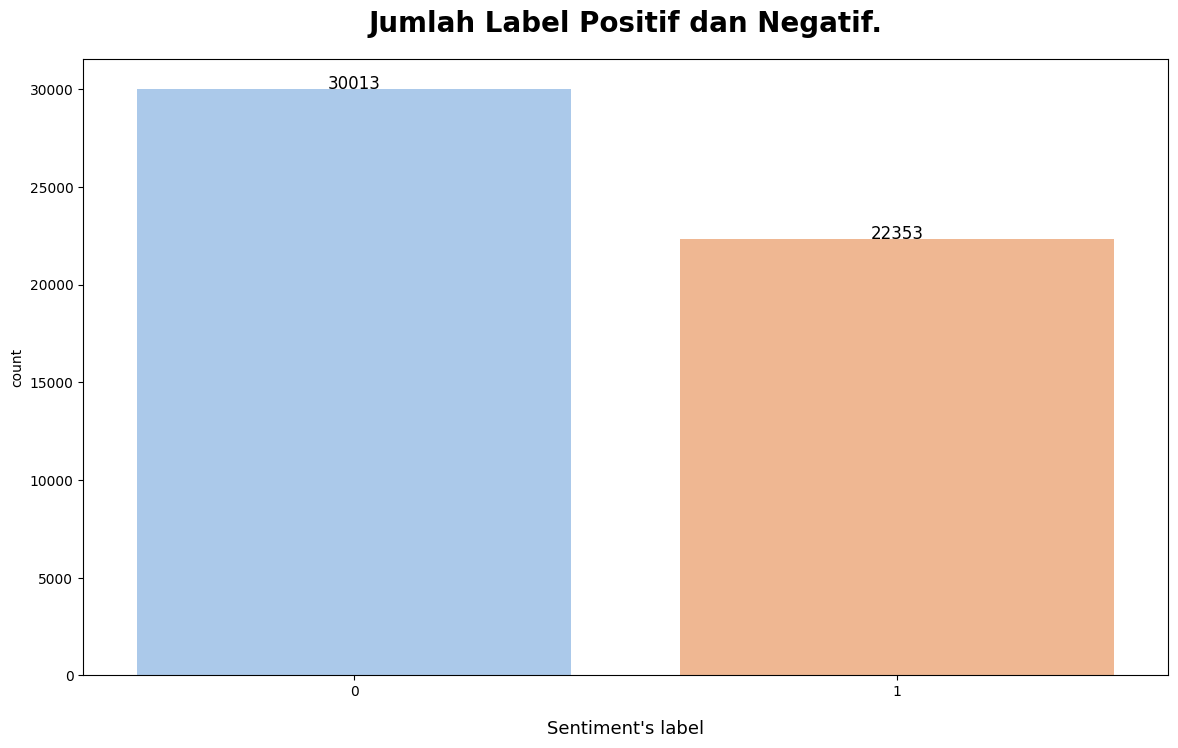

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualisasi bar chart untuk sentimen positif dan negatif
plt.figure(figsize=(14, 8))
ax = sns.countplot(x='sentiment', data=maxs, palette="pastel")

# Menambahkan nilai pada bar chart
for rect in ax.patches:
    ax.text(rect.get_x() + rect.get_width() / 2, rect.get_height() + 3.25,
            int(rect.get_height()), ha='center', fontsize=12)

# Menambahkan judul dan label
plt.title("Jumlah Label Positif dan Negatif.", fontsize=20, fontweight='bold', pad=20)
plt.xlabel("Sentiment's label", fontsize=13, labelpad=15)
plt.ylim(0)  # Mengatur batas y-axis agar tidak ada nilai negatif
plt.show()


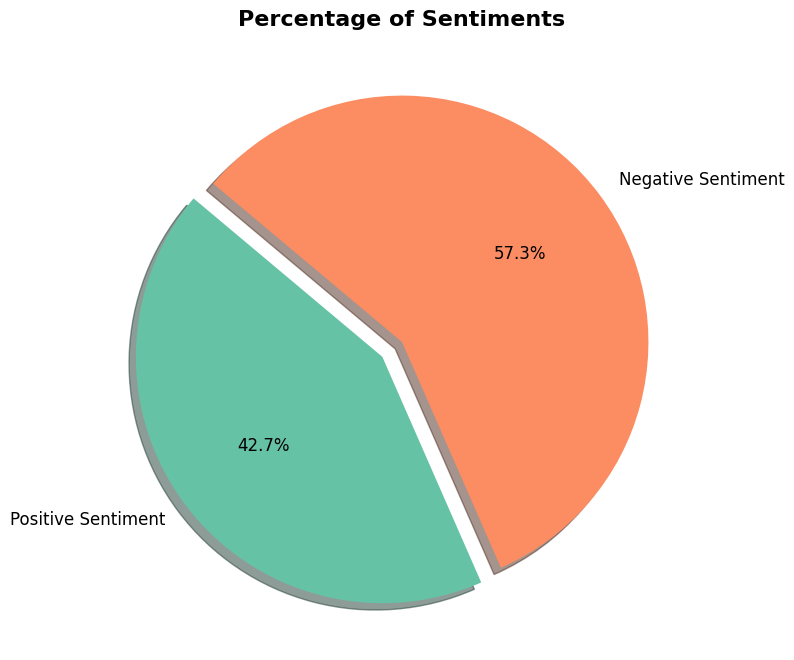

In [ ]:
import matplotlib.pyplot as plt

# Menghitung persentase sentimen
train_pct_pos = maxs.sentiment.value_counts()[1] / maxs.sentiment.value_counts().sum() * 100
train_pct_neg = maxs.sentiment.value_counts()[0] / maxs.sentiment.value_counts().sum() * 100

# Menyiapkan data untuk diagram pie
labels = ['Positive Sentiment', 'Negative Sentiment']
sizes = [train_pct_pos, train_pct_neg]
colors = ['#66c2a5', '#fc8d62']  # Warna untuk pie chart
explode = (0.1, 0)  # Memberikan efek meledak untuk bagian pertama (positive sentiment)

# Membuat diagram pie
plt.figure(figsize=(8, 8))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=140, textprops={'fontsize': 12})

# Menambahkan judul
plt.title("Percentage of Sentiments", fontsize=16, fontweight='bold')
plt.show()


## Wordcloud

In [ ]:
!gdown --id 1Lhn9xHVcTver1FfdtCkY3uJrmgfmb-ew

import pandas as pd

maxs = pd.read_csv('hasil_prepocessing.csv')

maxs.head()

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1Lhn9xHVcTver1FfdtCkY3uJrmgfmb-ew
To: /content/hasil_labeling2.csv
100% 1.01M/1.01M [00:00<00:00, 11.7MB/s]


,Unnamed: 0,content,sentiment,final_text,token,stop_review,stem_review
0,0,padahal bagus kalau bisa putar lewat aplikanya...,0,padahal bagus kalau bisa putar lewat aplikanya...,"['bagus', 'putar', 'aplikanya', 'langsung']","['bagus', 'putar', 'aplikanya', 'langsung']",bagus putar aplikanya langsung
1,1,coba dulu,0,coba dahulu,['coba'],['coba'],coba
2,2,coba dulu,1,coba dahulu,['coba'],['coba'],coba
3,3,kirain diputar harus download aplikasi strea...,1,kirain diputar harus unduh aplikasi streaming ...,"['kirain', 'diputar', 'unduh', 'aplikasi', 'st...","['kirain', 'diputar', 'unduh', 'aplikasi', 'st...",kirain putar unduh aplikasi streaming adeuh
4,4,oky,1,oky,['oky'],['oky'],oky


### Wordcloud Positif

In [ ]:
print(maxs['stem_review'].isna().sum())  # Jumlah NaN
print(maxs['stem_review'].dtypes)       # Tipe data kolom

1154
object


In [ ]:
maxs['stem_review'] = maxs['stem_review'].fillna('')  # Ganti NaN dengan string kosong
maxs['stem_review'] = maxs['stem_review'].astype(str)  # Ubah semua elemen menjadi string

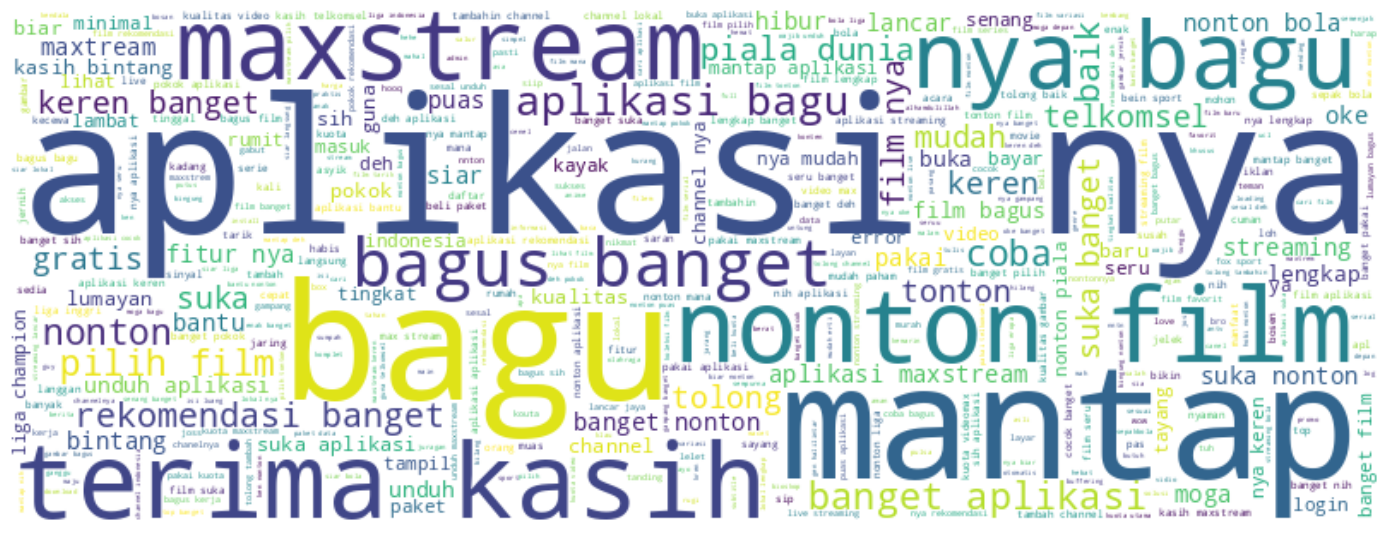

In [ ]:
#install library
from wordcloud import WordCloud
import matplotlib.pyplot as plt

sentiment_pos = ' '.join([review for review in maxs['stem_review'][maxs['sentiment'] == 1]])

# create object wordcloud
w_pos = WordCloud(background_color="white",
                  width=800, height=300, max_font_size=200,
                  max_words=500).generate(sentiment_pos)

plt.figure(figsize=(14,8))
plt.axis("off")
plt.tight_layout()
plt.imshow(w_pos, interpolation="bilinear")
plt.show()

### Wordcloud Nergatif

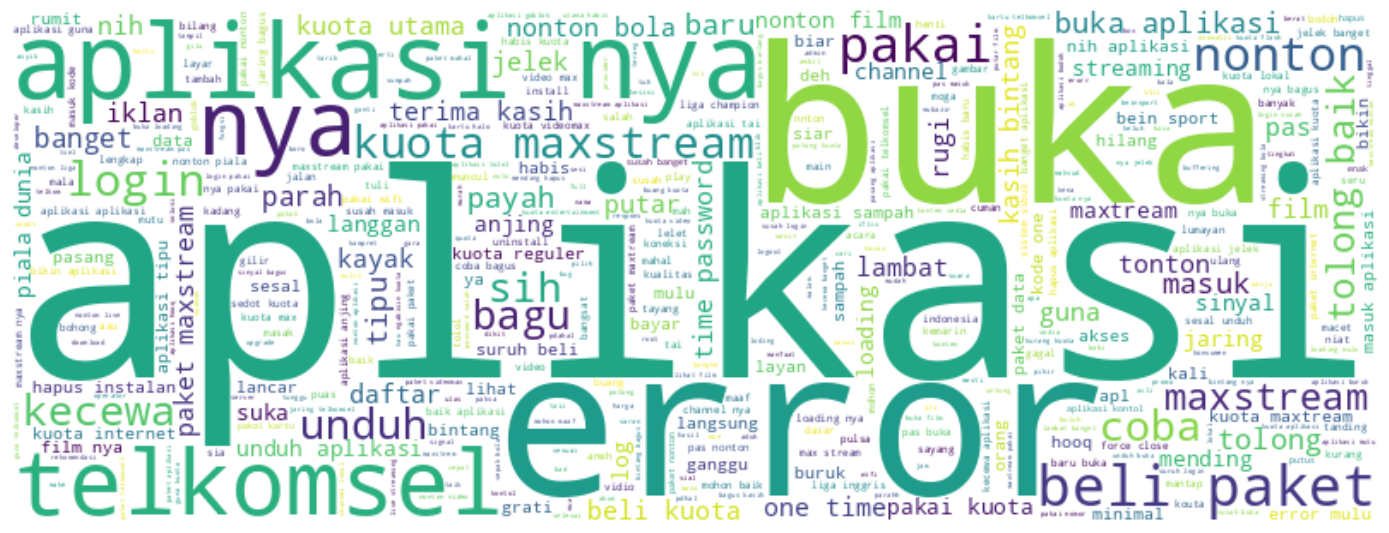

In [ ]:
sentiment_pos = ' '.join([review for review in maxs['stem_review'][maxs['sentiment'] == 0]])

# create object wordcloud
w_pos = WordCloud(background_color="white",
                  width=800, height=300, max_font_size=200,
                  max_words=500).generate(sentiment_pos)

plt.figure(figsize=(14,8))
plt.axis("off")
plt.tight_layout()
plt.imshow(w_pos, interpolation="bilinear")
plt.show()

## top 10 kata negatif dan postif

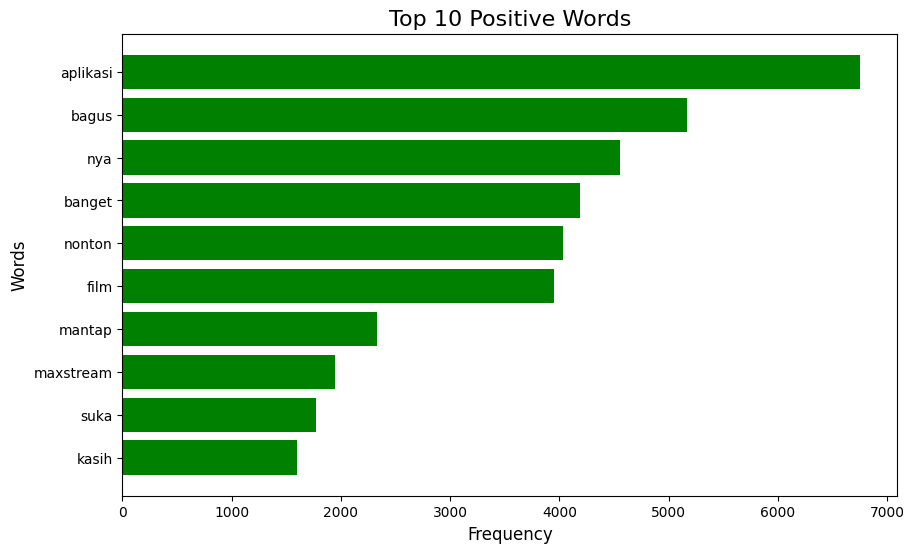

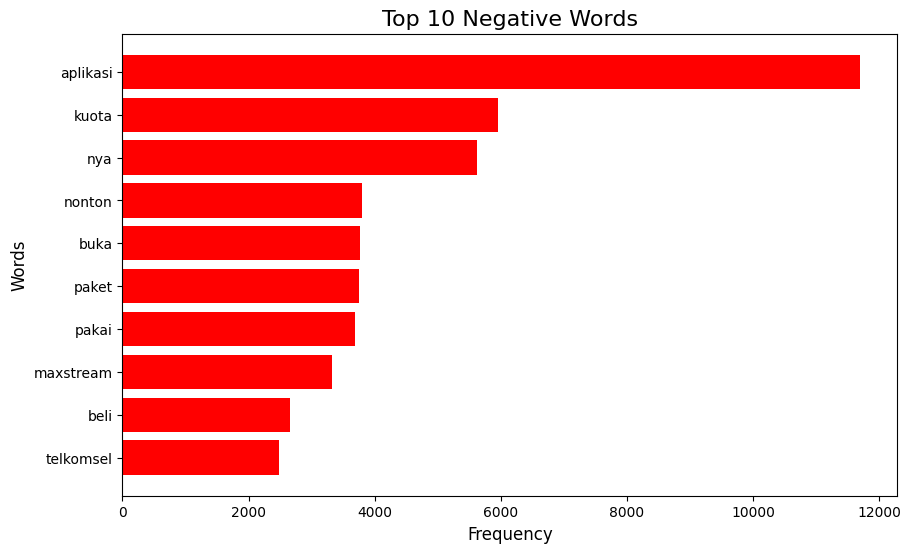

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import matplotlib.pyplot as plt

# Pisahkan data positif dan negatif
sentiment_pos = ' '.join([review for review in maxs['stem_review'][maxs['sentiment'] == 1]])
sentiment_neg = ' '.join([review for review in maxs['stem_review'][maxs['sentiment'] == 0]])

# Fungsi untuk mendapatkan 10 kata yang paling sering muncul
def get_top_n_words(corpus, n=10):
    vectorizer = CountVectorizer(stop_words='english')  # Menghapus kata umum
    X = vectorizer.fit_transform([corpus])
    word_freq = pd.DataFrame(list(zip(vectorizer.get_feature_names_out(), X.toarray().flatten())), columns=["Word", "Frequency"])
    word_freq = word_freq.sort_values(by="Frequency", ascending=False)
    return word_freq.head(n)

# Mendapatkan 10 kata yang paling sering muncul
top_positive_words = get_top_n_words(sentiment_pos, n=10)
top_negative_words = get_top_n_words(sentiment_neg, n=10)

# Visualisasi dengan Bar Chart untuk Positif
plt.figure(figsize=(10, 6))
plt.barh(top_positive_words['Word'], top_positive_words['Frequency'], color='green')
plt.title('Top 10 Positive Words', fontsize=16)
plt.xlabel('Frequency', fontsize=12)
plt.ylabel('Words', fontsize=12)
plt.gca().invert_yaxis()  # Membalikkan urutan agar yang paling sering muncul ada di atas
plt.show()

# Visualisasi dengan Bar Chart untuk Negatif
plt.figure(figsize=(10, 6))
plt.barh(top_negative_words['Word'], top_negative_words['Frequency'], color='red')
plt.title('Top 10 Negative Words', fontsize=16)
plt.xlabel('Frequency', fontsize=12)
plt.ylabel('Words', fontsize=12)
plt.gca().invert_yaxis()  # Membalikkan urutan agar yang paling sering muncul ada di atas
plt.show()


# Modeling

## 1.Menggunakan model Ml

In [3]:
!gdown --id 1_xlxtp5XQmtyovPeF5PtQvEhqqfHHTK-

import pandas as pd
import numpy as np

maxs = pd.read_csv('hasil_preprocessing2.csv')

X = maxs['stem_review']
y = maxs['sentiment']

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1_xlxtp5XQmtyovPeF5PtQvEhqqfHHTK-
To: /content/hasil_preprocessing2.csv
100% 16.4M/16.4M [00:00<00:00, 195MB/s]


In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score
from tqdm import tqdm  # Progress bar

# Inisialisasi variabel untuk menyimpan hasil
results = []

# Model yang akan diuji
models = {
    'SVM': SVC(kernel='linear'),
    'Naive Bayes': MultinomialNB(),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42)
}

# Progress bar untuk test size dan model
test_sizes = np.arange(0.1, 0.4, 0.1)
total_iterations = len(test_sizes) * len(models)  # Total iterasi
with tqdm(total=total_iterations, desc="Progress") as pbar:
    # Looping untuk berbagai ukuran test size (random state tetap 42)
    for test_size in test_sizes:
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=42)

        # Vectorize data
        vectorizer = TfidfVectorizer(use_idf=True, smooth_idf=False)
        X_train_vect = vectorizer.fit_transform(X_train)
        X_test_vect = vectorizer.transform(X_test)

        for model_name, model in models.items():
            # Train model
            model.fit(X_train_vect, y_train)

            # Predict
            y_pred = model.predict(X_test_vect)

            # Evaluate
            accuracy = accuracy_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred, average='weighted')
            precision = precision_score(y_test, y_pred, average='weighted')

            # Simpan hasil
            results.append({
                'Test Size': test_size,
                'Model': model_name,
                'Accuracy': accuracy,
                'Recall': recall,
                'Precision': precision
            })

            # Update progress bar
            pbar.update(1)

# Konversi hasil ke DataFrame
results_df = pd.DataFrame(results)

# Urutkan berdasarkan akurasi
sorted_results = results_df.sort_values(by='Accuracy', ascending=False)

# Tampilkan hasil
print(sorted_results.head(10))


Progress: 100%|██████████| 16/16 [18:20<00:00, 68.80s/it]

    Test Size          Model  Accuracy    Recall  Precision
12        0.4            SVM  0.818017  0.818017   0.817903
8         0.3            SVM  0.814386  0.814386   0.814174
4         0.2            SVM  0.813634  0.813634   0.813475
6         0.2  Random Forest  0.813634  0.813634   0.813298
14        0.4  Random Forest  0.811333  0.811333   0.811198
2         0.1  Random Forest  0.810960  0.810960   0.810665
10        0.3  Random Forest  0.809930  0.809930   0.809609
0         0.1            SVM  0.809242  0.809242   0.809183
13        0.4    Naive Bayes  0.799637  0.799637   0.801801
5         0.2    Naive Bayes  0.797212  0.797212   0.798852


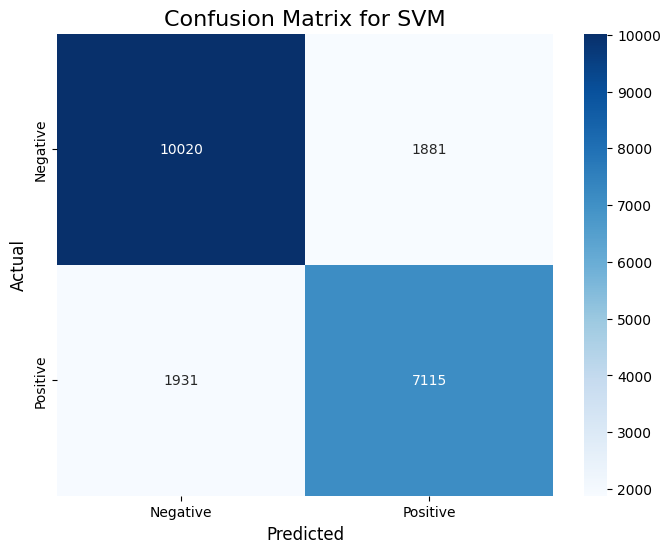

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Ambil model terbaik berdasarkan hasil akurasi tertinggi
best_model_info = sorted_results.iloc[0]

# Model terbaik dan parameter terkait
best_model_name = best_model_info['Model']
best_test_size = best_model_info['Test Size']

# Split data dengan parameter terbaik
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=best_test_size, random_state=42)

# Vectorize data
vectorizer = TfidfVectorizer(use_idf=True, smooth_idf=False)
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)

# Pilih model terbaik
best_model = models[best_model_name]

# Latih model terbaik
best_model.fit(X_train_vect, y_train)

# Prediksi dengan model terbaik
y_pred = best_model.predict(X_test_vect)

# Hitung confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualisasi Confusion Matrix
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title(f'Confusion Matrix for {best_model_name}', fontsize=16)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.show()


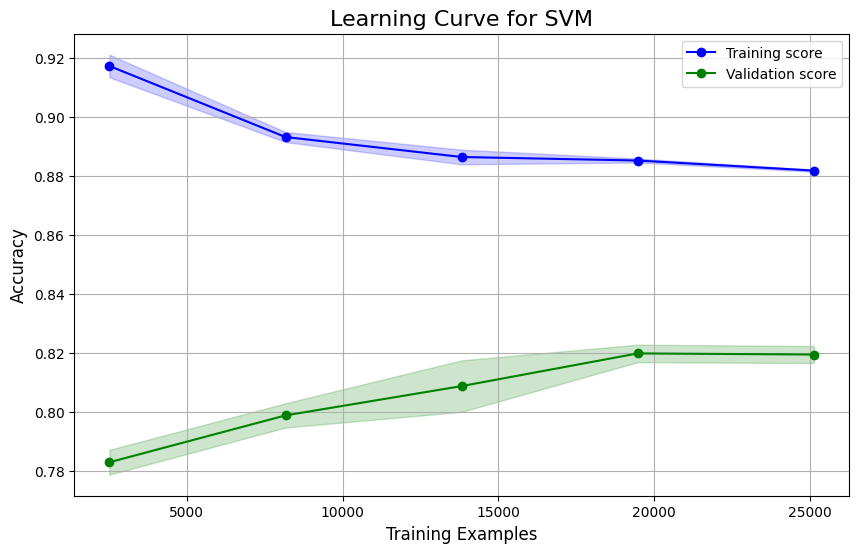

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import learning_curve

# Ambil informasi model terbaik berdasarkan akurasi tertinggi
best_model_info = sorted_results.iloc[0]
best_model_name = best_model_info['Model']
best_test_size = best_model_info['Test Size']

# Split data dengan parameter terbaik
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=best_test_size, random_state = 42)

# Vectorize data
vectorizer = TfidfVectorizer(use_idf=True, smooth_idf=False)
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)

# Pilih model terbaik
best_model = models[best_model_name]

# Fungsi untuk menggambar learning curve
def plot_learning_curve(estimator, X, y, cv=5, train_sizes=np.linspace(0.1, 1.0, 5)):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, train_sizes=train_sizes, scoring='accuracy', n_jobs=-1
    )

    # Hitung rata-rata dan standar deviasi
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    # Plot learning curve
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training score')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.2)
    plt.plot(train_sizes, test_mean, 'o-', color='green', label='Validation score')
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='green', alpha=0.2)

    plt.title(f'Learning Curve for {best_model_name}', fontsize=16)
    plt.xlabel('Training Examples', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.legend(loc='best')
    plt.grid()
    plt.show()

# Plot learning curve untuk model terbaik
plot_learning_curve(best_model, X_train_vect, y_train)


## 2.Menggunakan Model LSTM

### Spliting diawal untuk mencegah kebocoran data

In [10]:
!gdown --id 1_xlxtp5XQmtyovPeF5PtQvEhqqfHHTK-

import pandas as pd
import numpy as np

maxs = pd.read_csv('hasil_preprocessing2.csv')

X = maxs['stem_review']
y = maxs['sentiment']

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1_xlxtp5XQmtyovPeF5PtQvEhqqfHHTK-
To: /content/hasil_preprocessing2.csv
100% 16.4M/16.4M [00:00<00:00, 37.7MB/s]


In [11]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

#spliting data terbaik dari model ML
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size= 0.4, random_state=42)

In [12]:
# Mengecek nilai unik di kolom 'kolom'
unique_values = maxs['sentiment'].unique()
print(unique_values)

[0 1]


### Tokenization dan Squence


Apa Itu Tokenization dan Padding?
1. Tokenization adalah proses mengubah teks menjadi angka. Setiap kata diberi indeks unik (token) berdasarkan kamus yang dibuat dari teks.
2. Padding digunakan untuk menyamakan panjang setiap sequence (urutan kata) agar bisa diproses dalam model, terutama model seperti LSTM yang membutuhkan input dengan ukuran yang seragam.

In [15]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from gensim.models import KeyedVectors
from tensorflow.keras.initializers import Constant

# Pastikan data X_train dalam bentuk string
X_train = X_train.astype(str)

# Ganti NaN atau None dengan string kosong
X_train = X_train.fillna('').astype(str)
X_test = X_test.fillna('').astype(str)

# 1. Tokenizer
tokenizer = Tokenizer(num_words=10000, oov_token="<unk>")  # Batasi jumlah kata yang digunakan dan tentukan token OOV
tokenizer.fit_on_texts(X_train)  # Fit tokenizer pada data latih

# Ubah teks menjadi urutan bilangan integer
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Tentukan panjang maksimum urutan
MAX_SEQ_LENGTH = max(len(tokens) for tokens in X_train_seq)

# Padding untuk urutan yang lebih pendek agar memiliki panjang yang sama
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_SEQ_LENGTH, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_SEQ_LENGTH, padding='post')


In [16]:
# Print the padded sequences for X_train and X_test
print("X_train_padded:")
print(X_train_pad)
print("\nX_test_padded:")
print(X_test_pad)

X_train_padded:
[[5067  749   54 ...    0    0    0]
 [1271    0    0 ...    0    0    0]
 [   2   12   33 ...    0    0    0]
 ...
 [  17    6    9 ...    0    0    0]
 [ 274 1353   29 ...    0    0    0]
 [3577   88  317 ...    0    0    0]]

X_test_padded:
[[   5   92    0 ...    0    0    0]
 [ 630    0    0 ...    0    0    0]
 [4720    1    2 ...    0    0    0]
 ...
 [  14    0    0 ...    0    0    0]
 [   2   66  203 ...    0    0    0]
 [   1    0    0 ...    0    0    0]]


### Membuat Embedding Matrix dengan Pretrained Word2Vec

In [17]:
!gdown --id 1YUQ0FZ2oPhsCWl0E574YmbNwiJENLBXJ

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1YUQ0FZ2oPhsCWl0E574YmbNwiJENLBXJ
To: /content/word2vec-300.wordvectors
100% 1.20M/1.20M [00:00<00:00, 120MB/s]


In [18]:
# 2. Memuat model Word2Vec
WORD_EMBEDDING_PATH = 'word2vec-300.wordvectors'  # Path ke model Word2Vec
word2vec_model = KeyedVectors.load(WORD_EMBEDDING_PATH, mmap='r')

EMBEDDING_SIZE = 300  # Ukuran vektor embedding (misal, 300 dimensi untuk Word2Vec)

# 3. Membuat Matriks Embedding
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, EMBEDDING_SIZE))  # Matriks embedding kosong

# Loop untuk mencocokkan kata dalam tokenizer dengan vektor embedding dari model Word2Vec
for word, i in tokenizer.word_index.items():
    if word in word2vec_model:  # Jika kata ada dalam model Word2Vec
        embedding_matrix[i] = word2vec_model[word]  # Ambil vektor embedding dari Word2Vec dan masukkan ke dalam matriks embedding

# 4. Verifikasi Matriks Embedding
print(f"Ukuran matriks embedding: {embedding_matrix.shape}")

Ukuran matriks embedding: (13532, 300)


In [19]:
print(embedding_matrix[7])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


### Architecture

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.layers import GlobalMaxPool1D
from tensorflow.keras.initializers import Constant
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall

# Membuat model sederhana
model = Sequential()

# Layer embedding dengan pretrained embedding matrix
model.add(Embedding(
    input_dim=len(tokenizer.word_index) + 1,  # Ukuran vocabulary
    output_dim=EMBEDDING_SIZE,                # Dimensi embedding
    embeddings_initializer=Constant(embedding_matrix),  # Pretrained embedding
    input_length=MAX_SEQ_LENGTH,              # Panjang sequence
))

# Layer LSTM untuk pemrosesan urutan
model.add(LSTM(128, dropout=0.5, return_sequences=True))
model.add(LSTM(128, dropout=0.5, return_sequences=True))
model.add(GlobalMaxPool1D())
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

# Dense layer untuk klasifikasi
model.add(Dense(1, activation='sigmoid'))  # Output layer untuk binary classification

# Compile model
model.compile(Adam(learning_rate=3e-3), loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall()])

#Latih model
history = model.fit(
    X_train_pad,
    y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_test_pad, y_test)
)

Epoch 1/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 250s 492ms/step - accuracy: 0.7451 - loss: 0.5014 - precision_1: 0.7192 - recall_1: 0.6380 - val_accuracy: 0.8232 - val_loss: 0.3942 - val_precision_1: 0.8036 - val_recall_1: 0.7816
Epoch 2/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 259s 487ms/step - accuracy: 0.8432 - loss: 0.3699 - precision_1: 0.8176 - recall_1: 0.8090 - val_accuracy: 0.8191 - val_loss: 0.4009 - val_precision_1: 0.7761 - val_recall_1: 0.8166
Epoch 3/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 239s 487ms/step - accuracy: 0.8605 - loss: 0.3260 - precision_1: 0.8352 - recall_1: 0.8385 - val_accuracy: 0.8219 - val_loss: 0.4060 - val_precision_1: 0.7978 - val_recall_1: 0.7871
Epoch 4/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 258s 481ms/step - accuracy: 0.8769 - loss: 0.2904 - precision_1: 0.8538 - recall_1: 0.8560 - val_accuracy: 0.8184 - val_loss: 0.4357 - val_precision_1: 0.7905 - val_recall_1: 0.7886
Epoch 5/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 236s 481ms/step - accuracy: 0.8792 - loss: 0.2718 - precision_1: 0.8518 

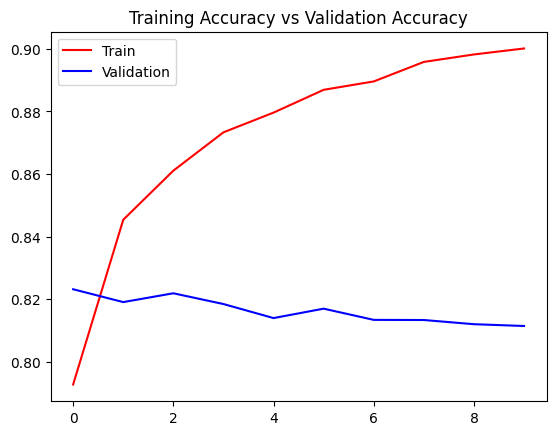

In [22]:
import matplotlib.pyplot as plt

plt.title('Training Accuracy vs Validation Accuracy')

plt.plot(history.history['accuracy'], color='red',label='Train')
plt.plot(history.history['val_accuracy'], color='blue',label='Validation')

plt.legend()

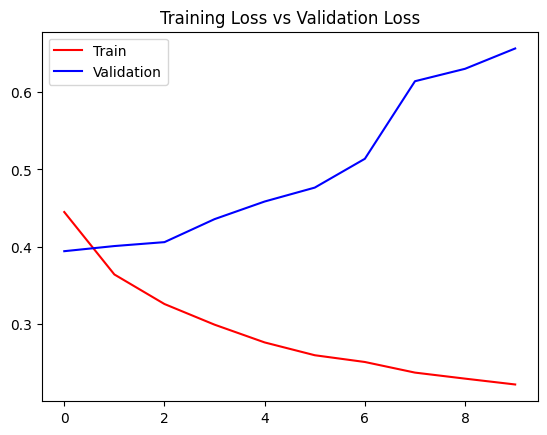

In [23]:
plt.title('Training Loss vs Validation Loss')

plt.plot(history.history['loss'], color='red',label='Train')
plt.plot(history.history['val_loss'], color='blue',label='Validation')

plt.legend()